Load Data

In [1]:
# --- Imports & paths ---
from pathlib import Path
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Project ROOT (works in / or /notebooks)
ROOT = Path.cwd().resolve().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

# Load engineered dataset
engineered_path = ROOT / "data" / "processed" / "loan_default_engineered.csv"
assert engineered_path.exists(), f"Engineered dataset not found at {engineered_path}. Run 02_feature_engineering.ipynb first."

df = pd.read_csv(engineered_path)
print("Loaded:", engineered_path)
print("Shape:", df.shape)
df.head()

Loaded: C:\Users\sauna\DS Projects\Financial_Analytics_LDP\data\processed\loan_default_engineered.csv
Shape: (10000, 8)


,employed,bank_balance,annual_salary,DEFAULT,log_bank_balance,log_annual_salary,balance_to_salary,employed_x_log_salary
0,1,8754.36,532339.56,0,9.077421,13.185039,0.016445,13.185039
1,0,9806.16,145273.56,0,9.190868,11.886381,0.067501,0.000000
2,1,12882.60,381205.68,0,9.463710,12.851097,0.033794,12.851097
3,1,6351.00,428453.88,0,8.756525,12.967941,0.014823,12.967941
4,1,9427.92,461562.00,0,9.151537,13.042374,0.020426,13.042374


Select all features and taget

In [2]:
# Feature set & target
TARGET = "DEFAULT"

FEATURES = [
    "employed",
    "log_bank_balance",
    "log_annual_salary",
    "balance_to_salary",
    "employed_x_log_salary",
]

# Basic sanity
missing_cols = [c for c in FEATURES + [TARGET] if c not in df.columns]
assert not missing_cols, f"Missing columns: {missing_cols}. Did you save engineered features?"

X = df[FEATURES].copy()
y = df[TARGET].copy()

X.shape, y.shape, y.mean().round(4)  # show class rate (~0.033)


((10000, 5), (10000,), np.float64(0.0333))

Use best model for scoring PD

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Best model pipeline
logit_final = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        solver="liblinear"
    ))
])

# Fit on the full dataset (after you’ve already validated model choice in 03)
logit_final.fit(X, y)

print("Fitted final logistic pipeline on full engineered dataset.")


Fitted final logistic pipeline on full engineered dataset.


Compute all PD

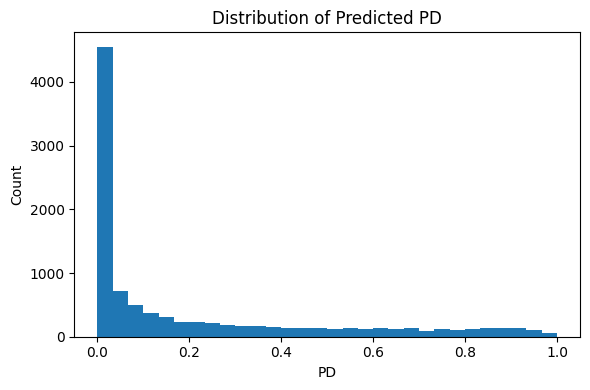

,count,mean,std,min,25%,50%,75%,max
PD,10000.0,0.207441,0.282416,9.236056e-27,0.001829,0.052819,0.337876,1.0


In [4]:
# Probability of Default for each row
pd_scores = logit_final.predict_proba(X)[:, 1]
df_scored = df.copy()
df_scored["PD"] = pd_scores

# Quick peek: distribution of PDs
plt.figure(figsize=(6,4))
plt.hist(df_scored["PD"], bins=30)
plt.title("Distribution of Predicted PD")
plt.xlabel("PD")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

df_scored[["PD"]].describe().T


Threshold classification @ 0.5

In [5]:
# Fixed threshold classification (thr=0.5)
thr_fixed = 0.5
df_scored["pred_fixed_0_5"] = (df_scored["PD"] >= thr_fixed).astype(int)

# See the class counts this produces
df_scored["pred_fixed_0_5"].value_counts().to_frame("count")


,count
pred_fixed_0_5,
0,8196
1,1804


Capacity based classification

In [6]:
# Capacity-based: flag top K% as default
K = 0.10  # e.g., top 10% riskiest
n = len(df_scored)
k_cut = int(np.ceil(K * n))

order = np.argsort(-df_scored["PD"].values)  # descending PD
flag_idx = order[:k_cut]

df_scored["pred_topK"] = 0
df_scored.loc[df_scored.index[flag_idx], "pred_topK"] = 1

# Check counts
pd.DataFrame({
    "topK_percent": [K],
    "n_flagged": [df_scored["pred_topK"].sum()],
    "portfolio_size": [n]
})


,topK_percent,n_flagged,portfolio_size
0,0.1,1000,10000


Simple risk segmentation

In [7]:
# Simple 3-band risk segmentation
high_cut = np.quantile(df_scored["PD"], 1 - 0.10)  # top 10%
review_cut = np.quantile(df_scored["PD"], 1 - 0.25)  # next 15%

def band(pd_):
    if pd_ >= high_cut:
        return "High"
    elif pd_ >= review_cut:
        return "Review"
    else:
        return "Standard"

df_scored["risk_band"] = df_scored["PD"].apply(band)

df_scored["risk_band"].value_counts().to_frame("count")


,count
risk_band,
Standard,7500
Review,1500
High,1000


Save outputs

In [8]:
# Save scored outputs
out_dir = ROOT / "reports"
out_dir.mkdir(parents=True, exist_ok=True)

columns_to_keep = FEATURES + [TARGET, "PD", "pred_fixed_0_5", "pred_topK", "risk_band"]
scored_path = out_dir / "scored_customers.csv"
df_scored[columns_to_keep].to_csv(scored_path, index=False)

print("Saved scored file to:", scored_path)
df_scored[columns_to_keep].head()


Saved scored file to: C:\Users\sauna\DS Projects\Financial_Analytics_LDP\reports\scored_customers.csv


,employed,log_bank_balance,log_annual_salary,balance_to_salary,employed_x_log_salary,DEFAULT,PD,pred_fixed_0_5,pred_topK,risk_band
0,1,9.077421,13.185039,0.016445,13.185039,0,0.035087,0,0,Standard
1,0,9.190868,11.886381,0.067501,0.000000,0,0.022645,0,0,Standard
2,1,9.463710,12.851097,0.033794,12.851097,0,0.249749,0,0,Standard
3,1,8.756525,12.967941,0.014823,12.967941,0,0.004119,0,0,Standard
4,1,9.151537,13.042374,0.020426,13.042374,0,0.049060,0,0,Standard


Check flagged outputs

In [9]:
# How many are flagged by each policy?
counts = pd.DataFrame({
    "policy": ["fixed_0_5", "topK_10pct"],
    "n_flagged": [df_scored["pred_fixed_0_5"].sum(), df_scored["pred_topK"].sum()],
    "portfolio": [len(df_scored), len(df_scored)]
})
counts["flag_rate"] = (counts["n_flagged"] / counts["portfolio"]).round(4)
counts


,policy,n_flagged,portfolio,flag_rate
0,fixed_0_5,1804,10000,0.1804
1,topK_10pct,1000,10000,0.1000
